In [1]:
using ReinforcementLearningAnIntroduction

┌ Info: Precompiling ReinforcementLearningAnIntroduction [02c1da58-b9a1-11e8-0212-f9611b8fe936]
└ @ Base loading.jl:1260
┌ Info: Skipping precompilation since __precompile__(false). Importing ReinforcementLearningAnIntroduction [02c1da58-b9a1-11e8-0212-f9611b8fe936].
└ @ Base loading.jl:1033
┌ Warning: Incompatibility detected between CUDA and LLVM 8.0+; disabling debug info emission for CUDA kernels
└ @ CUDAnative /home/tj/.julia/packages/CUDAnative/hfulr/src/CUDAnative.jl:114


In [2]:
env = BlackJackEnv(;init=(BlackJack.Hands(13, [1, 2], true), BlackJack.Hands(2, [2], false)))

ns, na = length(get_observation_space(env)), length(get_action_space(env))

(220, 2)

In [3]:
init_state = get_state(observe(env))

27

In [4]:
const GOLD_VAL = -0.27726

-0.27726

In [5]:
stick_action = findall(x -> x == :stick, BlackJack.ACTIONS)[]

table = fill(1, size(BlackJack.INDS)...)
table[:, 10:11, :] .= stick_action
table = reshape(table, :);

π_behavior = RandomPolicy(DiscreteSpace(1:na))

RandomPolicy(DiscreteSpace{UnitRange{Int64}}(1:2))

In [6]:
Base.@kwdef struct StoreMSE <: AbstractHook
    mse::Vector{Float64} = []
end

(f::StoreMSE)(::PostEpisodeStage, agent, env, obs) = push!(f.mse, (GOLD_VAL - agent.policy.π_target.learner.approximator(init_state))^2)


In [7]:
agent = Agent(
    policy=OffPolicy(
        VBasedPolicy(
            learner=MonteCarloLearner(
                approximator=TabularApproximator(n_state=ns),
                kind=FIRST_VISIT,
                sampling=ORDINARY_IMPORTANCE_SAMPLING
                ),
            mapping= (obs, V) -> begin
                values = zeros(na)
                values[table[get_state(obs)]] = 1
                values
            end
            ),
        π_behavior
        ),
    trajectory=EpisodicCompactSARTSATrajectory()
)

Agent{OffPolicy{VBasedPolicy{MonteCarloLearner{ReinforcementLearningAnIntroduction.FirstVisit,TabularApproximator{1,Array{Float64,1}},CachedSampleAvg{Float64},ReinforcementLearningAnIntroduction.OrdinaryImportanceSampling},var"#10#11",GreedyExplorer},RandomPolicy{DiscreteSpace{UnitRange{Int64}},Random.MersenneTwister}},EpisodicCompactSARTSATrajectory{Tuple{Int64,Int64,Float32,Bool,Int64,Int64},Tuple{Array{Float32,1},Array{Bool,1},Array{Int64,1},Array{Int64,1}}},Symbol}(OffPolicy{VBasedPolicy{MonteCarloLearner{ReinforcementLearningAnIntroduction.FirstVisit,TabularApproximator{1,Array{Float64,1}},CachedSampleAvg{Float64},ReinforcementLearningAnIntroduction.OrdinaryImportanceSampling},var"#10#11",GreedyExplorer},RandomPolicy{DiscreteSpace{UnitRange{Int64}},Random.MersenneTwister}}(VBasedPolicy{MonteCarloLearner{ReinforcementLearningAnIntroduction.FirstVisit,TabularApproximator{1,Array{Float64,1}},CachedSampleAvg{Float64},ReinforcementLearningAnIntroduction.OrdinaryImportanceSampling},var"

In [8]:
hook = StoreMSE()

StoreMSE(Float64[])

In [15]:
run(agent, env, StopAfterEpisode(10000, is_show_progress=true), hook)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04m


StoreMSE([0.0768731076, 0.0768731076, 8.66670421871111, 5.1859131076, 3.5241051076000005, 2.5940108853777786, 0.0768731076, 0.0496131076, 0.02795063846419752, 0.01506510759999999  …  8.095737924432831e-5, 8.044265940061232e-5, 7.992968357419253e-5, 7.941845074900165e-5, 7.890895990957866e-5, 8.564772929702644e-5, 8.511807560442953e-5, 8.459017016877427e-5, 8.406401197283954e-5, 8.35396000000088e-5])

In [16]:
function mse_of_ordinary_sampling()
    agent = Agent(
        policy=OffPolicy(
            VBasedPolicy(
                learner=MonteCarloLearner(
                    approximator=TabularApproximator(n_state=ns),
                    kind=FIRST_VISIT,
                    sampling=ORDINARY_IMPORTANCE_SAMPLING
                    ),
                mapping= (obs, V) -> begin
                    values = zeros(na)
                    values[table[get_state(obs)]] = 1
                    values
                end
                ),
            π_behavior
            ),
        trajectory=EpisodicCompactSARTSATrajectory()
    )
    hook = StoreMSE()
    run(agent, env, StopAfterEpisode(10000, is_show_progress=false), hook)
    hook.mse
end

mse_of_ordinary_sampling (generic function with 1 method)

In [17]:
function mse_of_weighted_sampling()
    agent = Agent(
        policy=OffPolicy(
            VBasedPolicy(
                learner=MonteCarloLearner(
                    approximator=TabularApproximator(n_state=ns),
                    kind=FIRST_VISIT,
                    sampling=WEIGHTED_IMPORTANCE_SAMPLING,
                    returns=(CachedSum{Int}(), CachedSum{Int}())
                    ),
                mapping= (obs, V) -> begin
                    values = zeros(na)
                    values[table[get_state(obs)]] = 1
                    values
                end
                ),
            π_behavior
            ),
        trajectory=EpisodicCompactSARTSATrajectory()
    )
    hook = StoreMSE()
    run(agent, env, StopAfterEpisode(10000, is_show_progress=false),hook)
    hook.mse
end

mse_of_weighted_sampling (generic function with 1 method)

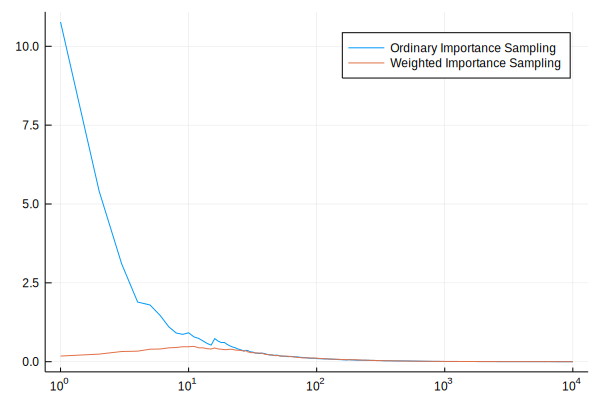

In [18]:
using Plots, StatsBase

plot(mean((mse_of_ordinary_sampling() for _ in 1:100)); xscale=:log10, label="Ordinary Importance Sampling")
plot!(mean((mse_of_weighted_sampling() for _ in 1:100)); xscale=:log10, label="Weighted Importance Sampling")